In [2]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 10
CROP_SIZE = 224
IMAGE_SHAPE = (400, 400)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("../../../dataset/processed/awa2/mnetv1/train")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("../../../dataset/processed/awa2/mnetv1/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("../../../dataset/processed/awa2/mnetv1/val")


print(device)

cuda:0


In [3]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

10805 1346 1346 ['antelope', 'cow', 'deer', 'elephant', 'giraffe', 'horse', 'lion', 'rabbit', 'sheep', 'squirrel', 'zebra']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


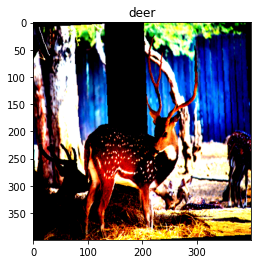

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


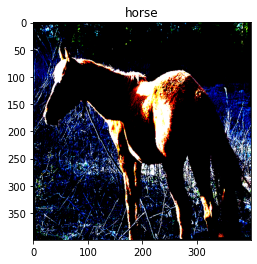

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


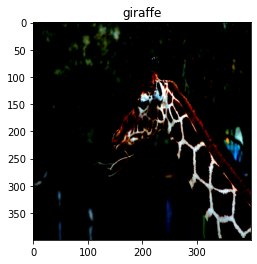

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


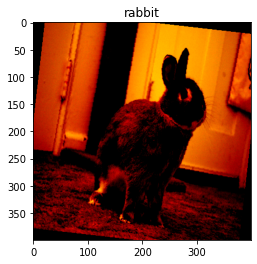

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


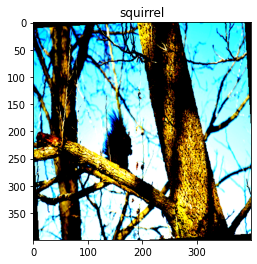

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


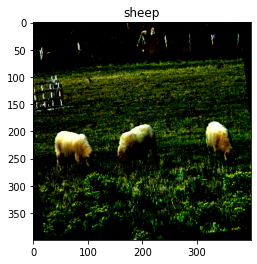

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


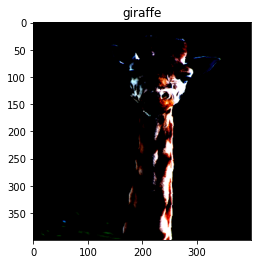

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


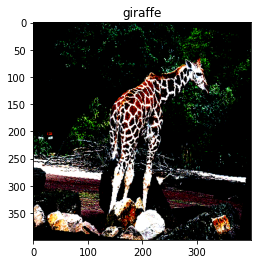

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


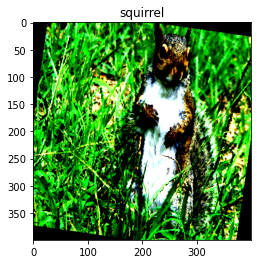

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


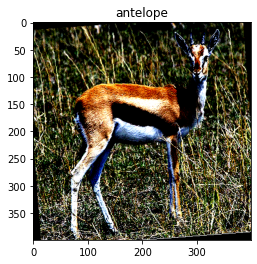

In [17]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()

In [ ]:
model = torchvision.models.mobilenet_v2(num_classes=len(train_set.classes), pretrained=False)
model = model.to(device)
model.eval()

c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
open("./logs/training_logs.csv", "w", newline="")
log_file = open("./logs/training_logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
    print(epoch, float(train_cost), train_score, float(test_cost), test_score)
    csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
    torch.save(model.state_dict(), f"./logs/models/model_e{epoch}.pth")

Train:   0%|          | 0/1081 [00:03<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

0 0.0008077575475908816 0.26302637667746415 0.008681678213179111 0.3922734026745914


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

1 0.0005490834591910243 0.4105506709856548 0.008340598084032536 0.513372956909361


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

2 0.0007573668262921274 0.5089310504396113 0.007574902381747961 0.5453194650817236


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

3 0.00038985407445579767 0.5785284590467377 0.005826263688504696 0.6344725111441307


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

4 0.00019569123105611652 0.6336881073577048 0.008790731430053711 0.7243684992570579


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

5 0.0005635495181195438 0.6789449329014345 0.003550998866558075 0.7384843982169391


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

6 0.00030716005130670965 0.7169828782970847 0.005069814622402191 0.7317979197622585


Train:   0%|          | 0/1081 [00:05<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

7 0.00046748382737860084 0.7441925034706155 0.0004991687601432204 0.7852897473997028


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

8 0.00013384468911681324 0.765756594169366 0.0003319632669445127 0.8031203566121843


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

9 0.0006775312940590084 0.7838963442850532 0.0022576148621737957 0.8172362555720654


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

10 0.00014521577395498753 0.8118463674224896 0.0018810619367286563 0.8202080237741456


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

11 0.0008595864055678248 0.8187875983341045 0.00036800940870307386 0.8313521545319466


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

12 4.061323852511123e-05 0.836094400740398 0.00035277463030070066 0.8469539375928677


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

13 0.00020799280900973827 0.8462748727441 0.0008400386432185769 0.8640416047548292


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

14 0.00010849200043594465 0.8546968995835261 0.0003993352293036878 0.8692421991084696


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

15 0.0005941918934695423 0.8565478944932902 0.000889093498699367 0.8551263001485884


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

16 0.0009950067615136504 0.8753354928273948 0.00013443213538266718 0.87444279346211


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

17 0.000687109655700624 0.8782970846830171 0.005136024206876755 0.8811292719167905


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

18 3.4617860364960507e-05 0.8869042110134198 0.0013321512378752232 0.8796433878157504


Train:   0%|          | 0/1081 [00:05<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

19 0.00012966760550625622 0.8880148079592781 0.0005744302761740983 0.887815750371471


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

20 7.292218651855364e-05 0.8982878297084683 0.0017696914728730917 0.8841010401188707


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

21 0.00016613725165370852 0.9028227672373901 0.00025515546440146863 0.8811292719167905


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

Val:   0%|          | 0/135 [00:00<?, ?it/s]

22 5.846500243933406e-07 0.9005090236001851 0.0019845529459416866 0.8803863298662704


Train:   0%|          | 0/1081 [00:04<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\collate.py", line 264, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\_utils\collate.py", line 160, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\storage.py", line 709, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(size * self._element_size(), device=device)
  File "c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\storage.py", line 222, in _new_shared
    return cls._new_using_filename_cpu(size)
RuntimeError: Couldn't open shared file mapping: <00000195E79DA2F2>, error code: <1455>


In [ ]:
with torch.no_grad():
    test_cost, test_score = loop_fn('val', test_set, test_loader, model, criterion, optimizer)
print(f"Testing Loss = {test_cost}, Accuracy = {test_cost}")